# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [4]:
print(X_train[0].shape)
print(X_train[0])
print(y_train)
print(y_test)
#print(X_train)

(32, 32, 3)
[[[  59.   62.   63.]
  [  43.   46.   45.]
  [  50.   48.   43.]
  ..., 
  [ 158.  132.  108.]
  [ 152.  125.  102.]
  [ 148.  124.  103.]]

 [[  16.   20.   20.]
  [   0.    0.    0.]
  [  18.    8.    0.]
  ..., 
  [ 123.   88.   55.]
  [ 119.   83.   50.]
  [ 122.   87.   57.]]

 [[  25.   24.   21.]
  [  16.    7.    0.]
  [  49.   27.    8.]
  ..., 
  [ 118.   84.   50.]
  [ 120.   84.   50.]
  [ 109.   73.   42.]]

 ..., 
 [[ 208.  170.   96.]
  [ 201.  153.   34.]
  [ 198.  161.   26.]
  ..., 
  [ 160.  133.   70.]
  [  56.   31.    7.]
  [  53.   34.   20.]]

 [[ 180.  139.   96.]
  [ 173.  123.   42.]
  [ 186.  144.   30.]
  ..., 
  [ 184.  148.   94.]
  [  97.   62.   34.]
  [  83.   53.   34.]]

 [[ 177.  144.  116.]
  [ 168.  129.   94.]
  [ 179.  142.   87.]
  ..., 
  [ 216.  184.  140.]
  [ 151.  118.   84.]
  [ 123.   92.   72.]]]
[6 9 9 ..., 9 1 1]
[3 8 8 ..., 5 1 7]


all idxs: [   29    30    35 ..., 49941 49992 49994]
slected idxs: [26421  4504  7985  4192 44545 10675 37334]
all idxs: [    4     5    32 ..., 49993 49998 49999]
slected idxs: [ 3230  7722 44395 48185  9054 43641  1502]
all idxs: [    6    13    18 ..., 49987 49991 49995]
slected idxs: [48906 34414 34499 47718 40911  1219 34463]
all idxs: [    9    17    21 ..., 49979 49982 49983]
slected idxs: [40365 11379  9332 25055 23772 19412 34244]
all idxs: [    3    10    20 ..., 49981 49984 49990]
slected idxs: [36177 28013  6498 31167  7933 26100  9452]
all idxs: [   27    40    51 ..., 49964 49980 49988]
slected idxs: [37006 10737 38874 42776 18318 27422 18262]
all idxs: [    0    19    22 ..., 49962 49966 49996]
slected idxs: [24389  7575  3712 43603 14443 36478 45225]
all idxs: [    7    11    12 ..., 49965 49978 49986]
slected idxs: [ 7624 21001  6876 38703  5328 44261 38422]
all idxs: [    8    62    69 ..., 49968 49976 49985]
slected idxs: [14613 16159 28324 17685 48558  4222 22300]
a

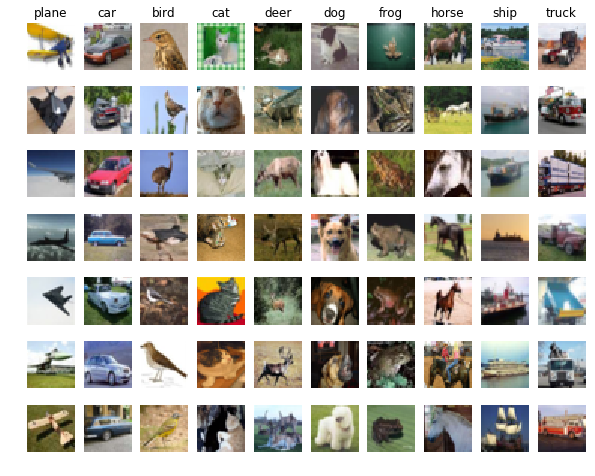

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    #print("y:",y,"----cls:", cls)
    idxs = np.flatnonzero(y_train == y)
    print("all idxs:",idxs)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    print("slected idxs:", idxs)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]
print(X_train.shape)
print(X_train.shape[0])

(5000, 32, 32, 3)
5000


In [6]:
# Reshape the image data into rows

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print (X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
"""
    num111_test = X_test.shape[0] #500 for test purpose
    num111_train = X_train.shape[0] #5000 for training purpose
    dists111 = np.zeros((num111_test, num111_train))
    print(dists111.shape)
    for i in range(num111_test):
      for j in range(num111_train):
        dists111[i,j]=np.linalg.norm(X_test[i]-X_train[j])
"""

(500, 5000)


In [16]:
"""
    num110_test = X_test.shape[0] #500 for test purpose
    num110_train = X_train.shape[0] #5000 for training purpose
    dists110 = np.zeros((num110_test, num110_train))
    print(dists110.shape)
    for i in range(num111_test):
        dists110[i,:]=np.linalg.norm(X_train[:]-X_test[i], axis=1)
"""

(500, 5000)


In [25]:
    num112_test = X_test.shape[0] #500 for test purpose
    num112_train = X_train.shape[0] #5000 for training purpose
    temp_test=np.zeros((num112_train, num112_test))
    temp_train=np.zeros((num112_test, num112_train))
    temp_middle=np.dot(X_test, X_train.T)*2
    print(temp_middle.shape)
    
    temp_test=temp_test+np.sum(np.square(X_test), axis=1)
    #print(temp_test)
    temp_test=temp_test.T
    print(temp_test.shape)
    temp_train=temp_train+np.sum(np.square(X_train), axis=1)
    
    dists112=np.sqrt(temp_test+temp_train-temp_middle)
  

(500, 5000)
(500, 5000)


In [26]:

#print(dists111[499,4999])
#print(dists110[499,4999])
print(dists112[499,4999])
#print(dists111[423,4929])
#print(dists110[423,4929])
print(dists112[423,4929])


8041.05223214
6099.074356


In [54]:
#x = np.array([[0, 13, 7], [9, 16, 5], [7, 2, 7]])
#print(np.argsort(x, axis=1))
#print(np.argsort(x, axis=1)[:,:2])
#print(np.argsort(x[1,:]))
"""
k=5
closes_index=np.argsort(dists112[1,:])[:k]
print(closes_index)
closest112_y=y_train[closes_index]
print(closest112_y)
k_count=np.zeros(10, dtype='uint8')
for j in range(k):
    k_count[closest112_y[j]]+=1
print(k_count)

print(np.argsort(k_count))
print("the right lable is %d", np.argsort(k_count)[9])

j_count=np.array([ 1,  0,  0,  0,  0,  3,  0,  0,  3,  1])
sorted_j=np.argsort(j_count)
m=9
final_j=sorted_j[m]
while(m-1>0):
    if(j_count[sorted_j[m-1]]==j_count[sorted_j[m]]):
        m=final_j=m-1
        print("final_j in loop:", final_j)
    else:
        break
print(final_j)
print(sorted_j[final_j])
print(sorted_j[9], sorted_j[8])
"""

[2192 4848 2166 2172 3644]
[9 8 8 8 0]
[1 0 0 0 0 0 0 0 3 1]
[1 2 3 4 5 6 7 0 9 8]
the right lable is %d 8
final_j in loop: 8
8
5
8 5


In [55]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [64]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


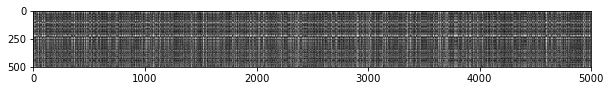

In [57]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*
The distinctly bright rows are extremely white or dark images(test). 
Same cause for the columns (train image)


In [69]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [68]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [73]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
  print('Good! The distance matrices are the same')
else:
  print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [75]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
  print('Good! The distance matrices are the same')
else:
  print ('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [76]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 24.254719 seconds
One loop version took 72.127483 seconds
No loop version took 0.487530 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [115]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#X_train_folds = []
#y_train_folds = []
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

#kf = KFold(n_splits=5)

#for train_index, test_index in kf.split(X_train):

#print(empty(shape(1,3072)).shape)

#X_train_folds, X_test_folds, y_train_folds, y_test_folds = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
pass
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

"""
c_X_test=X_train_folds[num_folds-1]
c_y_test=y_train_folds[num_folds-1]
c_X_train=np.zeros(shape=(0,3072))
c_y_train=[]
for j in range(num_folds-1):
    c_X_train=np.concatenate((c_X_train, X_train_folds[j]))
    c_y_train=np.concatenate((c_y_train, y_train_folds[j]))

k_classifier = KNearestNeighbor()
k_classifier.train(c_X_train, c_y_train)
k_dists = k_classifier.compute_distances_no_loops(c_X_test)
c_y_test_pred = k_classifier.predict_labels(k_dists, k=1)
"""
#print(len(k_choices))
#print(num_folds)

k_to_a_array = np.zeros((len(k_choices), num_folds))

print(k_to_a_array)

for i in range(num_folds):
    c_X_test=X_train_folds[i]
    c_y_test=y_train_folds[i]
    c_X_train=np.zeros(shape=(0,3072))
    c_y_train=[]
    for j in range(num_folds):
        if(i!=j):
            c_X_train=np.concatenate((c_X_train, X_train_folds[j]))
            c_y_train=np.concatenate((c_y_train, y_train_folds[j]))

    k_classifier = KNearestNeighbor()
    k_classifier.train(c_X_train, c_y_train)
    k_dists = k_classifier.compute_distances_no_loops(c_X_test)
    for j in range(len(k_choices)):
        y_test_pred = k_classifier.predict_labels(k_dists, k=k_choices[j])
# Compute and print the fraction of correctly predicted examples
        num_correct = np.sum(y_test_pred == c_y_test)
        accuracy = float(num_correct) / len(c_y_test)
        #print("j:", j, "    i:", i, "    accuracy:", accuracy)
        k_to_a_array[j, i] = accuracy

#print(k_to_a_array)

for ktoacount in range(len(k_choices)):
    k_to_accuracies[k_choices[ktoacount]]=k_to_a_array[ktoacount, :]
    

                       
# Compute and print the fraction of correctly predicted examples
    #num_correct = np.sum(y_test_pred == y_test)
    #accuracy = float(num_correct) / num_test
    #print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
    #print(c_X_train.shape)
    #print(c_Y_train.shape)

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
#pass
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies

for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


10
5
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


C:\Users\Lenovo\Downloads\cs231n\assignment1\cs231n\classifiers\k_nearest_neighbor.py:175: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  k_count[closest_y[j]]+=1


[[ 0.263  0.257  0.264  0.278  0.266]
 [ 0.239  0.249  0.24   0.266  0.254]
 [ 0.248  0.266  0.28   0.292  0.28 ]
 [ 0.262  0.282  0.273  0.29   0.273]
 [ 0.265  0.296  0.276  0.284  0.28 ]
 [ 0.26   0.295  0.279  0.283  0.28 ]
 [ 0.252  0.289  0.278  0.282  0.274]
 [ 0.27   0.279  0.279  0.282  0.285]
 [ 0.271  0.288  0.278  0.269  0.266]
 [ 0.256  0.27   0.263  0.256  0.263]]
k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.27

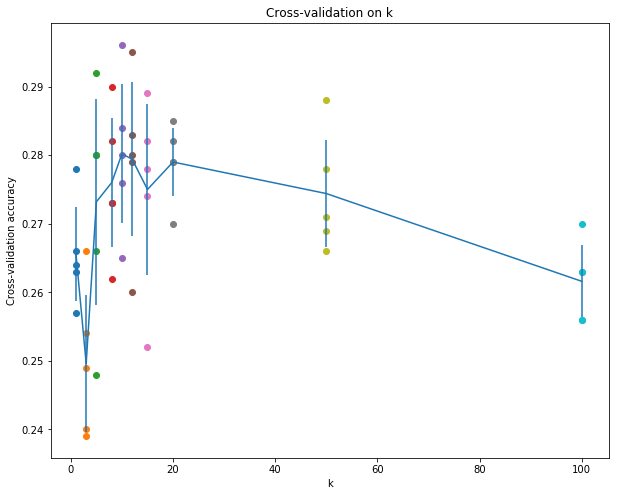

In [116]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [119]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k=0
best_meanv=0
for k,v in sorted(k_to_accuracies.items()):
    meanv=np.mean(v)
    if(meanv>best_meanv):
        best_k=k
        best_meanv=meanv

print(best_k)

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

10
Got 141 / 500 correct => accuracy: 0.282000
